<h1>Use Straw to Analyze Hi-C Data!</h1>

## Streaming in Hi-C Data

The ENCODE suite of tools for accessing and analyzing Hi-C Data includes the Straw API for streaming Hi-C data without needing to download any files. Straw currently supports Python, C++, R, MATLAB, and JavaScript. Here, we will be using the Straw API for Python.

The first step is to install straw on the machine:

Now we import the straw library (as well as some additional common libraries) into our code:

In [22]:
import numpy as np
import hicstraw
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

Here's a sample call which will pull data from the Hi-C file. This call extracts all reads from chromosome 4 at 50KB resolution with KR (Knight-Ruiz balancing algorithm) normalization from the combined MAPQ 30 map from Rao and Huntley et al. 2014

In [16]:
straw_obj = hicstraw.straw("oe", 'VC', '/Users/Akanksha/MaGroup/Genomic Hubs/workflow/data/GM12878/4DNData/4DNFI9YAVTI1.hic', '1', '1', 'BP', 100000) #params: (norm, hicfile, chr1loc, chr2loc, unit, binsize, is_synapse)
for i in range(10):
  print("{0}\t{1}\t{2}".format(straw_obj[i].binX, straw_obj[i].binY, straw_obj[i].counts))

0	0	319.5705871582031
0	100000	17.492212295532227
100000	100000	102.30449676513672
100000	200000	93.29180145263672
200000	200000	255.65647888183594
100000	500000	24.31380844116211
200000	500000	17.70379066467285
500000	500000	14.67416000366211
100000	600000	5.133296966552734
200000	600000	8.702865600585938


For infrequent calls, the code above works ok. But if you need to do more detailed analysis, you may want to look at some of the properties of the .hic file. Let's try just loading the .hic files into an object.

In [24]:
hic = hicstraw.HiCFile("/Users/Akanksha/MaGroup/Genomic Hubs/workflow/data/GM12878/4DNData/4DNFI9YAVTI1.hic")
print(hic)

Let's now print out the genomeID and list of resolutions in this file.

In [3]:
print(hic.getGenomeID()) #4DN data portal gm12878 is hg38
print(hic.getResolutions())

/var/lib/cwl/stga3f80174-ba8e-4d25-8491-09d0707bbd92/4DNFI823LSII.chrom.sizes
[10000000, 5000000, 2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000, 2000, 1000]


Let's now print out the chromosomes in this file.

In [4]:
for chrom in hic.getChromosomes():
  print(chrom.name, chrom.length)

ALL 3088269
1 248956422
2 242193529
3 198295559
4 190214555
5 181538259
6 170805979
7 159345973
8 145138636
9 138394717
10 133797422
11 135086622
12 133275309
13 114364328
14 107043718
15 101991189
16 90338345
17 83257441
18 80373285
19 58617616
20 64444167
21 46709983
22 50818468
X 156040895
Y 57227415


The "All" chromosome is a zoomed out all-by-all view that is used for Juicebox visualization. The remaining chromosomes are the actual ones used for any analysis.

Let's grab the matrix object for chromosome 4 at 5kb resolution.

In [25]:
matrix_object_chr1 = hic.getMatrixZoomData('1', '1', "observed", "VC", "BP", 100000)
print(matrix_object_chr1)

In [26]:
numpy_matrix_chr1 = matrix_object_chr1.getRecordsAsMatrix(10000000, 90000000, 10000000, 90000000)
print(numpy_matrix_chr1)

[[1.83087329e+03 7.70590820e+02 3.42695404e+02 ... 2.71782517e-01
  0.00000000e+00 4.16113079e-01]
 [7.70590820e+02 1.94358557e+03 7.76258850e+02 ... 0.00000000e+00
  6.57290637e-01 0.00000000e+00]
 [3.42695404e+02 7.76258850e+02 1.97898792e+03 ... 1.13157272e+00
  0.00000000e+00 4.33124095e-01]
 ...
 [2.71782517e-01 0.00000000e+00 1.13157272e+00 ... 1.82158972e+03
  1.13512231e+03 2.96175201e+02]
 [0.00000000e+00 6.57290637e-01 0.00000000e+00 ... 1.13512231e+03
  1.75112048e+03 4.55425842e+02]
 [4.16113079e-01 0.00000000e+00 4.33124095e-01 ... 2.96175201e+02
  4.55425842e+02 1.78537573e+03]]


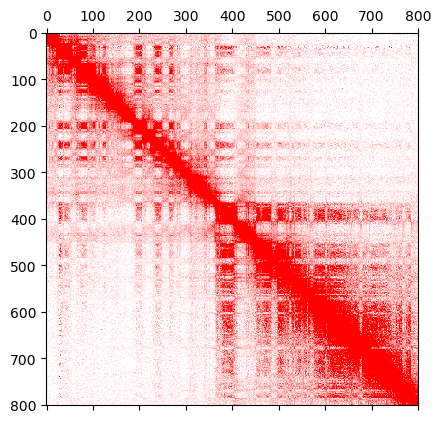

In [27]:
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1,1,1),(1,0,0)])
# helper function for plotting
def plot_hic_map(dense_matrix, maxcolor):
    plt.matshow(dense_matrix, cmap=REDMAP, vmin=0, vmax=maxcolor)
    plt.show()

plot_hic_map(numpy_matrix_chr1, 10)

Now let's plot some data!

## Sample Analysis
Here's some quick analysis that uses ENCODE Hi-C and ChIP-Seq data!

In [28]:
import pyBigWig

In [29]:
def plot_2dhic_1dtrack_map(dense_matrix, signal, vmin, vmax, cmap):
  d2 = dense_matrix # np.log(dense_matrix)
  d2[np.isnan(d2)] = 0
  d2[np.isinf(d2)] = 0
  fig = plt.figure()
  fig.set_figheight(12)
  fig.set_figwidth(8)
  spec = gridspec.GridSpec(ncols=1, nrows=2,
                         width_ratios=[1], wspace=1,
                         hspace=.1, height_ratios=[16, 30])
  ax0 = fig.add_subplot(spec[0])
  ax0.plot(np.arange(len(signal)), signal)
  ax1 = fig.add_subplot(spec[1])
  ax1.matshow(d2, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()

In [30]:
matrix_o = hic.getMatrixZoomData('1', '1', "observed", "KR", "BP", 100000)
numpy_matrix_o = matrix_o.getRecordsAsMatrix(0, 75000000, 0, 75000000)
nm = np.shape(numpy_matrix_o)[0]

In [43]:
# loading chipseq data
bw = pyBigWig.open("/Users/Akanksha/MaGroup/Genomic Hubs/workflow/data/GM12878/4DNData/4DNFIDPK7WFE_compartments.bw") # AB score
#bw2 = pyBigWig.open("https://www.encodeproject.org/files/ENCFF828CQV/@@download/ENCFF828CQV.bigWig") # H3K4me2	FC
signal = bw.stats("chr2", 0, 75000000, type="mean", nBins=nm)
#signal2 = bw2.stats("chr2", 0, 75000000, type="mean", nBins=nm)
#signal = np.log(np.asarray(signal) * np.asarray(signal2))

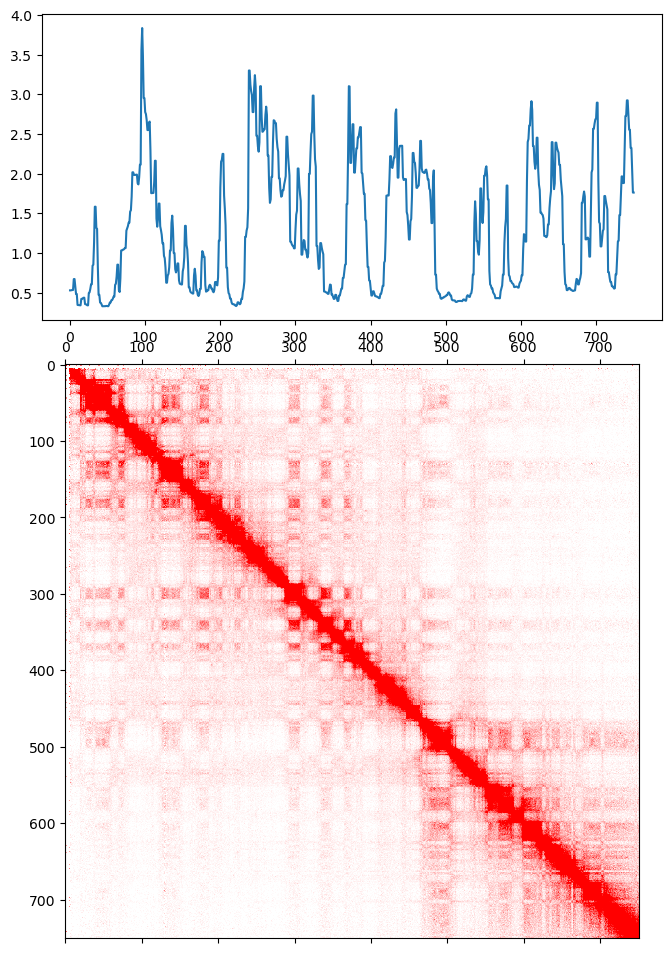

In [44]:
plot_2dhic_1dtrack_map(numpy_matrix_o, np.exp(signal), 0, 50, REDMAP)

In [45]:
matrix_oe = hic.getMatrixZoomData('1', '1', "oe", "VC", "BP", 100000)
numpy_matrix_oe = matrix_oe.getRecordsAsMatrix(0, 75000000, 0, 75000000)

/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_40295/1253140000.py:1: RuntimeWarning: divide by zero encountered in log
  plot_2dhic_1dtrack_map(np.log(numpy_matrix_oe), np.exp(signal), -1, 1, 'bwr')


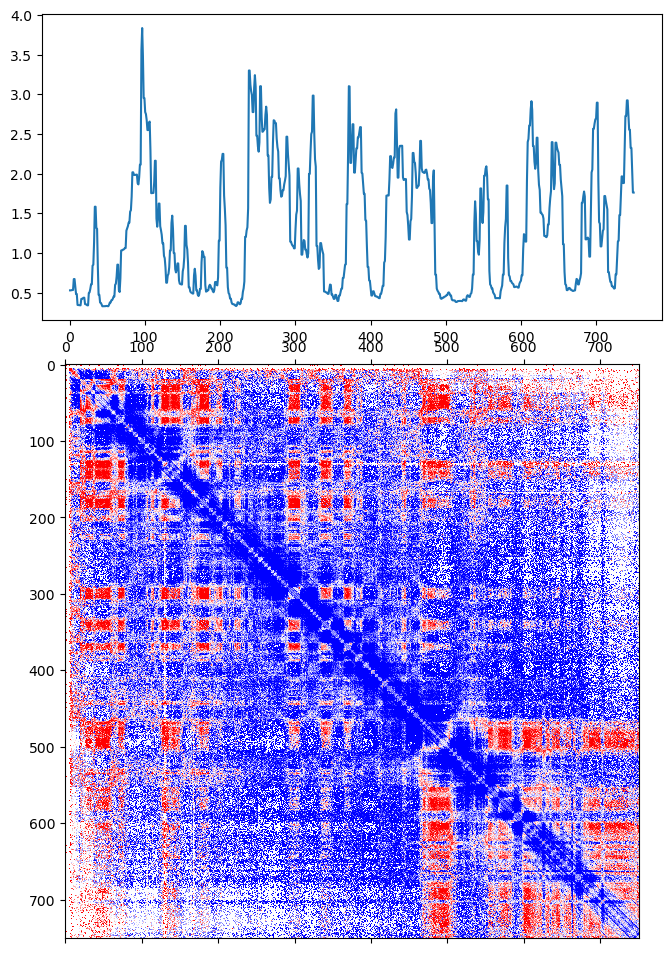

In [46]:
plot_2dhic_1dtrack_map(np.log(numpy_matrix_oe), np.exp(signal), -1, 1, 'bwr')

In [53]:
signal = np.exp(signal)
indices = np.argsort(signal)
signal2 = signal[indices]
print(signal2)

[ 1.38735685  1.38741501  1.38832741  1.38832741  1.3896934   1.38993546
  1.38995762  1.39217368  1.39334217  1.39334217  1.39980608  1.40446636
  1.40446636  1.40467063  1.40467063  1.40480353  1.40706862  1.40952017
  1.41172557  1.41478844  1.41657911  1.41889525  1.41889525  1.42041105
  1.42330607  1.42400205  1.42634563  1.42682195  1.42835144  1.43365788
  1.44111684  1.44813124  1.45469393  1.45514593  1.45553976  1.45553976
  1.45895631  1.45895631  1.46404075  1.46919722  1.46976516  1.4808555
  1.4808555   1.48259689  1.48259689  1.48352794  1.48392888  1.48478135
  1.48529542  1.4857104   1.48913007  1.48913007  1.49298246  1.49298246
  1.49569909  1.49686896  1.49698346  1.50032033  1.50639376  1.50728381
  1.51220812  1.51400737  1.52226975  1.52294331  1.52338704  1.52338704
  1.52455702  1.52505722  1.52514349  1.52818226  1.52873081  1.52873081
  1.53200598  1.53496521  1.53537608  1.53537608  1.53604434  1.53656646
  1.53656646  1.53796846  1.53796846  1.53829732  1.

In [51]:
numpy_matrix2 = numpy_matrix_oe.copy()
numpy_matrix2 = numpy_matrix2[:,indices]
numpy_matrix2 = numpy_matrix2[indices,:]


/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_40295/2840861348.py:1: RuntimeWarning: divide by zero encountered in log
  plot_2dhic_1dtrack_map(np.log(numpy_matrix2), signal2, -1, 1, 'bwr')


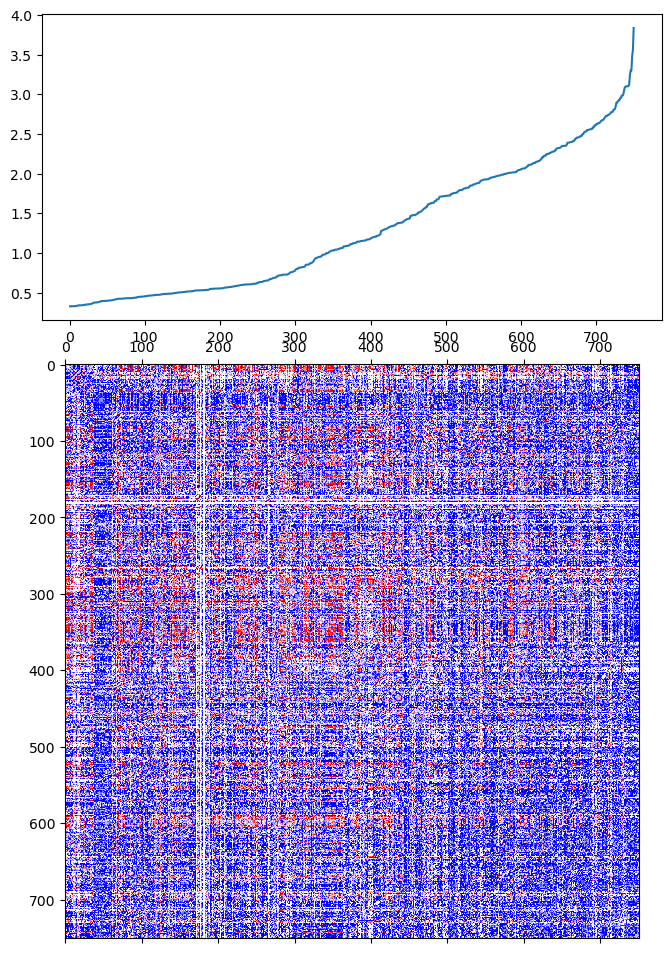

In [52]:
plot_2dhic_1dtrack_map(np.log(numpy_matrix2), signal2, -1, 1, 'bwr')